>## Saint George Classifier
Задача заключается в том, чтобы сделать классификатор наличия святого Георгия на изображении.

>### Dataset
>  Датасет, используемый в проекте, состоит из 5700 изображений, из которых 2360 изображений содержат Святого Георгия и 3340 - нет. Весь датасет разделен на 3 части: **70%** данных используется для обучения модели, **20%** для валидации и **10%** для финального тестирования. Причем в каждой из частей соотношение классов 40%-60%, поскольку изначальный датасет не сбалансирован. 


>### Используемая модель решения
> - Так как используемый датасет не велик и отсутствуют большие вычислительные мощности для обучения, построение модели с нуля навряд ли привело бы к классификатору с хорошей точностью. Более усовершенствованный подход (**Transfer learning**)   заключается  в использовании нейронной сети, предварительно обученной на большом наборе данных. В такой сети уже изучены функции, которые полезны для большинства проблем компьютерного зрения, и использование таких функций позволяет достичь большей точности, чем любой другой метод, который полагался бы только на доступные данные. 
>
> В проекте использовалась [Xception](https://keras.io/api/applications/) структура, предобученная на ImageNet dataset. Это относительно небольшая по размерам сеть имеет около 23М параметров и весит 88 Мб, при этом точность классификации на ImageNet составляет 79%. В сравнении, InceptionResNetV2, которая чуть лучше Xception, использует почти 56М параметров и весит 215Мб.
>
> Обучение данной модели происходит следующим образом
>
>1. Загрузим веса с ImageNet в Xception, из которой убраны верхние полносвязные слои, поскольку эти слои содержат в себе веса подходящие для классификации изображений в наборе данных ImageNet. Далее мы замораживаем все слои обрезанной Xception, после чего к данной модели добавляем два собственных, нетренированных, полносвязных слоя (последний слой это сигмойд) и производим обучение. После данной процедуры точность на training set  cоставляет **79%**, а  на validation достигает **80%**.
>2.  Чтобы ещё больше улучшить данный результат мы производим так называемый **Fine-tuning** верхних слоёв предобученной Xception. Для этого мы загружаем обученную на этапе 1 модель и размораживаем последние два блока Xception и повторно обучаем.  При этом используем в качестве алгоритма оптимизации SGD с низким  коэффициентом скорости обучения, чтобы не разрушить ранее полученный результат. Дообученная модель достигает точности в **89%** на training set и **84%** на validation.
>
> Проверив модель на данных, которых она никогда не видела (test dataset) и которые не использовались для настройки гиперпараметров, увидим точность **83%**. Данный результат можно улучшить путем увелечения времени обучения модели на 1 этапе. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
from tensorflow.keras.applications.xception import Xception

#### Data pre-processing and data augmentation

In [4]:
Image_Width=150
Image_Height=150
Image_Size=(Image_Width,Image_Height)
batch_siz = 32

In [5]:
path_georges = "D:\\Project_Georges\\georges"
filenames_georges = list(map(lambda x: path_georges + "\\" + x, os.listdir(path_georges) )) 
dictn_georges = { 'filename':filenames_georges, "class":np.ones(len(filenames_georges), dtype=int) }
df_1 = pd.DataFrame(dictn_georges)
df_1['class'] = df_1['class'].apply(lambda x: 'georges')

path_non_georges = "D:\\Project_Georges\\non_georges"
filenames_non_georges = list(map(lambda x: path_non_georges +"\\" + x, os.listdir(path_non_georges) )) 
dictn_non_georges = { 'filename':filenames_non_georges, "class":np.zeros(len(filenames_non_georges), dtype=int) }
df_0 = pd.DataFrame(dictn_non_georges)
df_0['class'] = df_0['class'].apply(lambda x: 'non_georges')

In [6]:
len(df_1), len(df_0)

(2360, 3340)

In [7]:
# Разбиваем наш датасет на training, validation, and test в соотношении 70%-20%-10%. Соотношение классов в каждом наборе 40%-60%.
alpha = np.round(len(df_0) / len(df_1) , 2 )

frac_1 = int(0.7*len(df_1))
frac_0 = int(0.7*alpha*len(df_1))

frac_1_val = int(0.9*len(df_1))
frac_0_val = int(0.9*alpha*len(df_1))

df_1 = df_1.sample(frac=1).reset_index(drop=True)
df_0 = df_0.sample(frac=1).reset_index(drop=True)


df_train = pd.concat([df_1.loc[ : frac_1-1 ], df_0.loc[ :frac_0 -1 ] ], axis=0)

df_val =  pd.concat([df_1.loc[ frac_1 : frac_1_val-1 ], df_0.loc[frac_0 :frac_0_val -1 ] ], axis=0)

df_test = pd.concat([df_1.loc[frac_1_val : ], df_0.loc[frac_0_val : ]],axis=0)

In [8]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  rotation_range=15,
                                  zoom_range=0.2,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col ="filename",
                                                    y_col="class",
                                                   target_size=Image_Size,
                                                   batch_size=batch_siz,
                                                   class_mode='binary')

Found 3997 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(df_val,
                                                              x_col ="filename",
                                                              y_col="class",
                                                              target_size=Image_Size,
                                                              batch_size=batch_siz,
                                                              class_mode='binary',
                                                              shuffle=False)

Found 1143 validated image filenames belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  x_col ="filename",
                                                  y_col="class",
                                                  target_size=Image_Size,
                                                  batch_size=batch_siz,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 560 validated image filenames belonging to 2 classes.


### Transfer learning

In [12]:
# Загружаем Xception модель (веса) за исключением верхних выходных слоёв
base_xcpt = Xception(include_top=False, weights = 'imagenet', pooling='avg', input_shape = (Image_Width,Image_Height,3)) 

In [12]:
# Добовляем наши верхние слои к Xception
def new_top_layers(base):
    x = base.output
    x = Dense(512 , activation='relu')(x)
    x = Dropout(0.4)(x)
    
    pred = Dense(1, activation= 'sigmoid')(x)
    
    return Model(inputs= base.input, outputs= pred)

In [13]:
# Собираем нашу модель, причем все веса основы (Xception) заморожены
def assemble_model(model, base):
    for layer in base.layers:
        layer.trainable = False
    model.compile(optimizer= 'rmsprop', loss= 'binary_crossentropy', metrics=['accuracy']) 

In [15]:
model = new_top_layers(base_xcpt)
assemble_model(model, base_xcpt )

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [14]:
#Инициализируем EarlyStopping и сохраняем (после model.fit) лучшую модель на диск
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=11)
checkpointer = ModelCheckpoint(filepath="D:\\Project_Georges\\top_weights.hdf5", verbose=1, save_best_only=True)

In [19]:
model.fit_generator(train_generator, epochs=15, steps_per_epoch= np.ceil(train_generator.samples/ train_generator.batch_size), 
         validation_data=validation_generator, validation_steps=np.ceil(validation_generator.samples/ validation_generator.batch_size),
         callbacks=[early_stop, checkpointer],
         verbose=1)

Epoch 1/15
124/125 [============================>.] - ETA: 6s - loss: 0.7004 - accuracy: 0.6441 
Epoch 00001: val_loss improved from inf to 0.52924, saving model to D:\Project_Georges\top_weights.hdf5
125/125 [==============================] - 844s 7s/step - loss: 0.7013 - accuracy: 0.6442 - val_loss: 0.5292 - val_accuracy: 0.7384
Epoch 2/15
124/125 [============================>.] - ETA: 6s - loss: 0.6077 - accuracy: 0.6991 
Epoch 00002: val_loss did not improve from 0.52924
125/125 [==============================] - 827s 7s/step - loss: 0.6080 - accuracy: 0.6988 - val_loss: 0.5548 - val_accuracy: 0.7533
Epoch 3/15
124/125 [============================>.] - ETA: 6s - loss: 0.5699 - accuracy: 0.7203 
Epoch 00003: val_loss did not improve from 0.52924
125/125 [==============================] - 834s 7s/step - loss: 0.5677 - accuracy: 0.7215 - val_loss: 0.5620 - val_accuracy: 0.7577
Epoch 4/15
124/125 [============================>.] - ETA: 6s - loss: 0.5418 - accuracy: 0.7400 
Epoch 0000

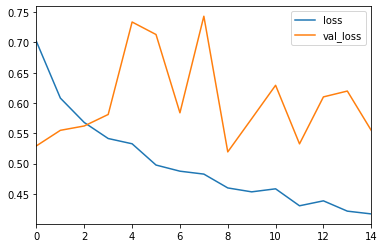

In [20]:
model_loss = pd.DataFrame(model.history.history)
model_loss[['loss','val_loss']].plot()

In [15]:
# Загружаем лучшую модель
model = load_model("D:\\Project_Georges\\top_weights.hdf5")

### Fine-tuning

In [16]:
# Проверяем какие слои заморожены
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001D72EC46A20> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D72EC46F60> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D72EC99710> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001D72EC99A90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D72EC99C18> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D72ECD00F0> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001D72ECD0470> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x000001D72ECD05F8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D72ECD0C88> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001D72ECD7048> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x00000

In [17]:
# Функция, которая размораживает верхние num_trainable слои
def finetune(model, num_trainable):
    for layer in model.layers[ : len(model.layers) - num_trainable]:
        layer.trainable = False
    for layer in model.layers[len(model.layers) - num_trainable : ]: 
        layer.trainable = True
        
    model.compile(loss='binary_crossentropy',
            optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
            metrics=['accuracy'])

In [18]:
# Размораживаем верхние 2 блока (блок 13 и 14) Xception (19 слоёв)
finetune(model, 19)

In [19]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001D72EC46A20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D72EC46F60> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D72EC99710> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001D72EC99A90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D72EC99C18> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D72ECD00F0> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001D72ECD0470> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x000001D72ECD05F8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D72ECD0C88> False
<tensorflow.python.keras.layers.core.Activation object at 0x000001D72ECD7048> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x0000

In [20]:
checkpointer_1 = ModelCheckpoint(filepath='D:\\Project_Georges\\finetune_model.hdf5', verbose=1, save_best_only=True)

In [21]:
# Повторно обучаем нашу модель с двумя размороженными блоками (13 и 14)
model.fit_generator(train_generator, epochs=15, steps_per_epoch= np.ceil(train_generator.samples/ train_generator.batch_size), 
         validation_data=validation_generator, validation_steps=np.ceil(validation_generator.samples/ validation_generator.batch_size),
         callbacks=[early_stop, checkpointer_1],
         verbose=1)

Epoch 1/15
124/125 [============================>.] - ETA: 6s - loss: 0.4311 - accuracy: 0.8020 
Epoch 00001: val_loss improved from inf to 0.44357, saving model to D:\Project_Georges\finetune_model.hdf5
125/125 [==============================] - 817s 7s/step - loss: 0.4304 - accuracy: 0.8021 - val_loss: 0.4436 - val_accuracy: 0.8154
Epoch 2/15
124/125 [============================>.] - ETA: 6s - loss: 0.3889 - accuracy: 0.8166 
Epoch 00002: val_loss improved from 0.44357 to 0.43968, saving model to D:\Project_Georges\finetune_model.hdf5
125/125 [==============================] - 809s 6s/step - loss: 0.3884 - accuracy: 0.8169 - val_loss: 0.4397 - val_accuracy: 0.8171
Epoch 3/15
124/125 [============================>.] - ETA: 6s - loss: 0.3797 - accuracy: 0.8265 
Epoch 00003: val_loss did not improve from 0.43968
125/125 [==============================] - 808s 6s/step - loss: 0.3793 - accuracy: 0.8264 - val_loss: 0.4401 - val_accuracy: 0.8128
Epoch 4/15
124/125 [========================

In [22]:
model = load_model("D:\\Project_Georges\\finetune_model.hdf5")
model.evaluate_generator(validation_generator)

[0.41998096120854217, 0.8433946]

### Predictions (test dataset)

In [23]:
results = model.predict_generator(test_generator, steps=np.ceil(test_generator.samples/ test_generator.batch_size))
print(classification_report(test_generator.classes, np.round(results[:,0])))
print(confusion_matrix(y_true= test_generator.classes, y_pred= np.round(results[:,0])))
print(test_generator.class_indices)

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       236
           1       0.83      0.88      0.86       324

    accuracy                           0.83       560
   macro avg       0.83      0.82      0.82       560
weighted avg       0.83      0.83      0.83       560

[[179  57]
 [ 39 285]]
{'georges': 0, 'non_georges': 1}
